## Imports

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import albumentations as A
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
for path in os.listdir("/kaggle/working/evaluation"):
    os.remove("/kaggle/working/evaluation/"+path)

In [3]:
# for path in os.listdir("/kaggle/working/Models"):
#     os.remove("/kaggle/working/Models/"+path)

## config

In [3]:
base_path = '/kaggle/working/'

if(not os.path.isdir(f"{base_path}Models")): os.mkdir(f"{base_path}Models")
if(not os.path.isdir(f"{base_path}evaluation")): os.mkdir(f"{base_path}evaluation")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")

TRAIN_DIR = "/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages"
VAL_DIR = "/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages"
# TRAIN_DIR = "Pix2Pix/ConcatenatedImages/val"
# VAL_DIR = "Pix2Pix/ConcatenatedImages/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 1
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 10
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISC = f"{base_path}Models/disc.pth.tar"
CHECKPOINT_GEN = f"{base_path}Models/gen.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
#         A.HorizontalFlip(p=0.0),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

Using 2 GPUs


## dataloader

In [5]:
class WordDataset(Dataset):
    def __init__(self, root_dir, val):
        self.root_dir = root_dir
#         self.list_files = os.listdir(self.root_dir)
#         self.list_files = [f'/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages/{i}.png' for i in range(1, 200000) if os.path.isdir(f'/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages/{i}.png')]
        if(val == False): self.list_files = [f'/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages/{i}.png' for i in range(1, 20000)]
        else: self.list_files = [f'/kaggle/input/typed-and-handwritten-hindi-text/ConcatenatedImages/{i}.png' for i in range(30000, 30010)]

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
#         img_path = os.path.join(self.root_dir, img_file)
        img_path = img_file
        image = np.array(Image.open(img_path))
        # input_image = image[:, :256, :]
        # target_image = image[:, 256:, :]
        input_image = image[:, :256]
        target_image = image[:, 256:]

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

## utils

In [6]:
import random

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
        
        # Plot the images
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        
        # Input image
        ax[0].imshow(x[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap="gray")
        ax[0].set_title('Input')
        ax[0].axis('off')
        
        # Generated image
        ax[1].imshow(y_fake[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
        ax[1].set_title('Generated')
        ax[1].axis('off')
        
        ax[2].imshow(y[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5, cmap="gray")
        ax[2].set_title('Target')
        ax[2].axis('off')
        
        plt.show()
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## discriminator

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(
                    in_channels, feature, stride=1 if feature == features[-1] else 2
                )
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1) # concatenate along the channel dimension
        x = self.initial(x)
        return self.model(x)

## generator

In [9]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False)
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) # 32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) # 16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) # 2

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1), # 1 x 1
            nn.ReLU(),
        )

        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)

        bottleneck = self.bottleneck(d7)

        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))

        return self.final_up(torch.cat([up7, d1], 1))

## training loop

In [9]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.amp.autocast('cuda'):
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.amp.autocast('cuda'):
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

## start train

=> Loading checkpoint


/tmp/ipykernel_30/1062254696.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=DEVICE)


=> Loading checkpoint


  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 157/157 [14:41<00:00,  5.61s/it, D_fake=0.238, D_real=0.671]


=> Saving checkpoint
=> Saving checkpoint


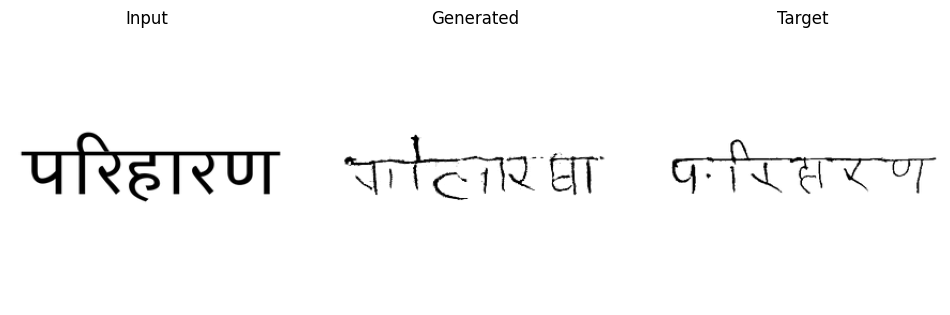

100%|██████████| 157/157 [14:31<00:00,  5.55s/it, D_fake=0.339, D_real=0.716]


=> Saving checkpoint
=> Saving checkpoint


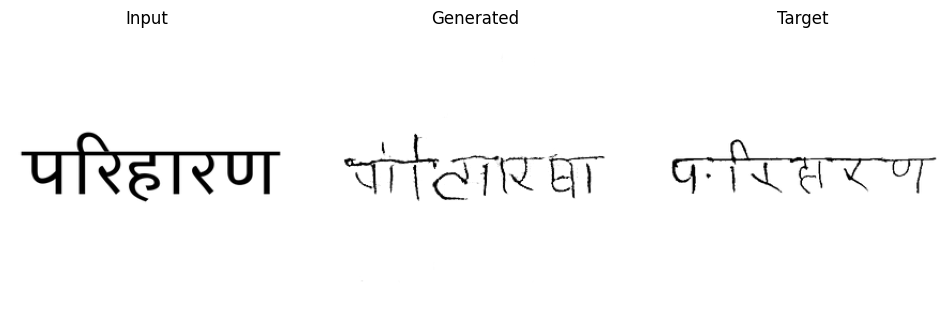

100%|██████████| 157/157 [14:32<00:00,  5.56s/it, D_fake=0.323, D_real=0.776]


=> Saving checkpoint
=> Saving checkpoint


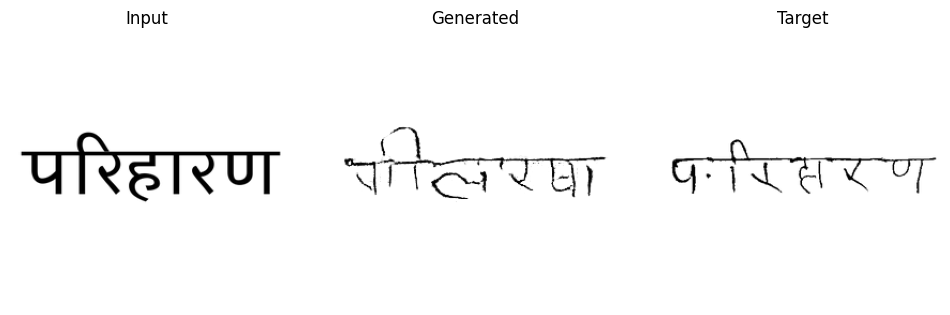

100%|██████████| 157/157 [14:25<00:00,  5.51s/it, D_fake=0.243, D_real=0.676]


=> Saving checkpoint
=> Saving checkpoint


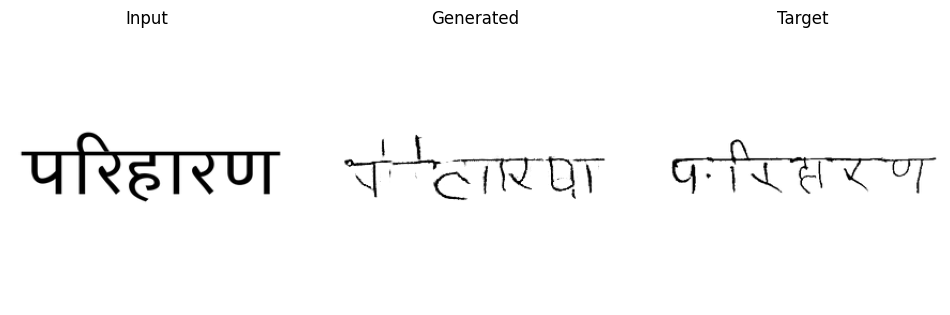

100%|██████████| 157/157 [14:24<00:00,  5.51s/it, D_fake=0.38, D_real=0.244] 


=> Saving checkpoint
=> Saving checkpoint


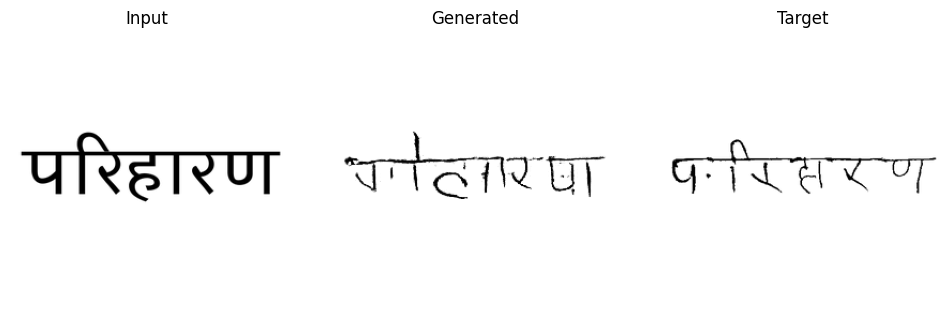

100%|██████████| 157/157 [14:24<00:00,  5.51s/it, D_fake=0.382, D_real=0.603]


=> Saving checkpoint
=> Saving checkpoint


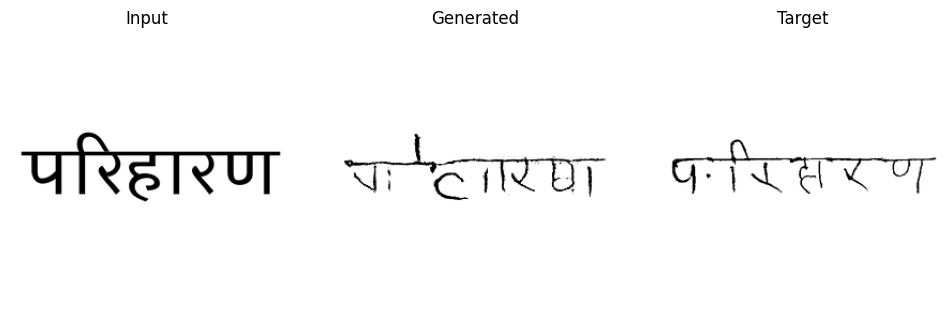

100%|██████████| 157/157 [14:26<00:00,  5.52s/it, D_fake=0.327, D_real=0.625]


=> Saving checkpoint
=> Saving checkpoint


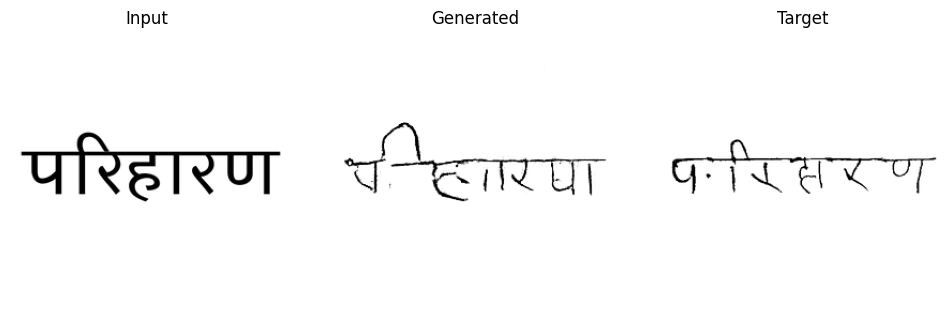

100%|██████████| 157/157 [14:27<00:00,  5.53s/it, D_fake=0.298, D_real=0.739]


=> Saving checkpoint
=> Saving checkpoint


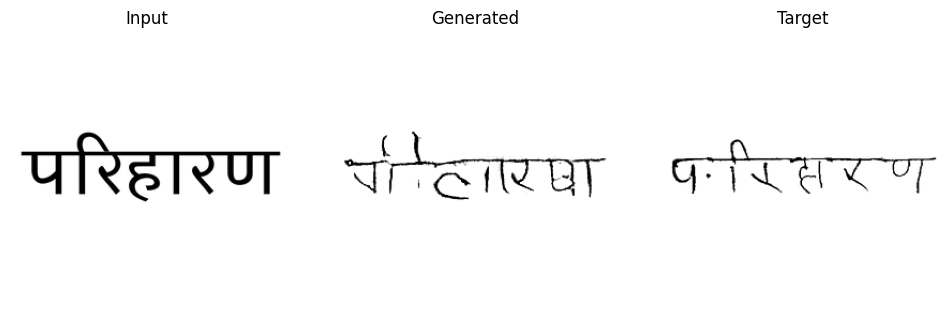

100%|██████████| 157/157 [14:28<00:00,  5.53s/it, D_fake=0.384, D_real=0.46] 


=> Saving checkpoint
=> Saving checkpoint


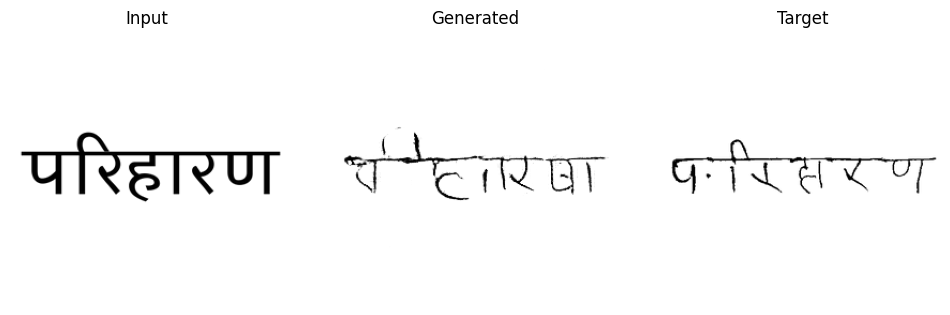

100%|██████████| 157/157 [14:28<00:00,  5.53s/it, D_fake=0.519, D_real=0.594]


=> Saving checkpoint
=> Saving checkpoint


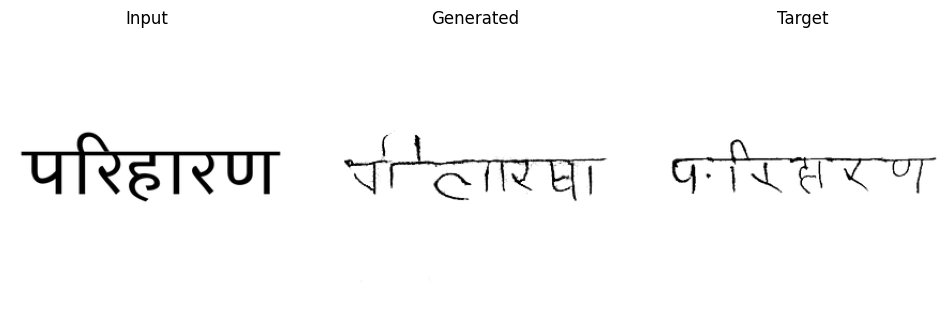

In [10]:
disc = Discriminator(in_channels=1).to(DEVICE)
gen = Generator(in_channels=1, features=64).to(DEVICE)

if num_gpus > 1:
    gen = nn.DataParallel(gen)  # Wrap the generator model
    disc = nn.DataParallel(disc)  # Wrap the discriminator model

opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
    )

train_dataset = WordDataset(root_dir=TRAIN_DIR, val=False)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
g_scaler = torch.amp.GradScaler('cuda')
d_scaler = torch.amp.GradScaler('cuda')
val_dataset = WordDataset(root_dir=VAL_DIR, val=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

for epoch in range(NUM_EPOCHS):
    train_fn(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
    )

    if SAVE_MODEL and epoch % 1 == 0:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

    save_some_examples(gen, val_loader, epoch, folder="evaluation")

#### Images generated using validation set

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

disc = Discriminator(in_channels=1).to(DEVICE)
gen = Generator(in_channels=1, features=64).to(DEVICE)

if num_gpus > 1:
    gen = nn.DataParallel(gen)  # Wrap the generator model
    disc = nn.DataParallel(disc)  # Wrap the discriminator model

opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
    )

train_dataset = WordDataset(root_dir=TRAIN_DIR, val=False)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
g_scaler = torch.amp.GradScaler('cuda')
d_scaler = torch.amp.GradScaler('cuda')
val_dataset = WordDataset(root_dir=VAL_DIR, val=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

=> Loading checkpoint


/tmp/ipykernel_30/1062254696.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=DEVICE)


=> Loading checkpoint


  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


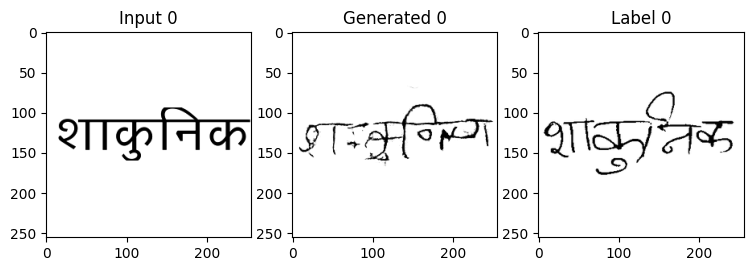

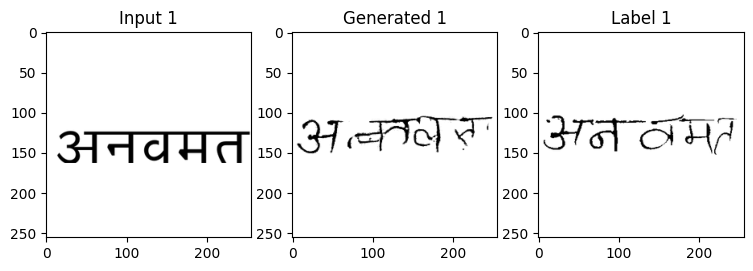

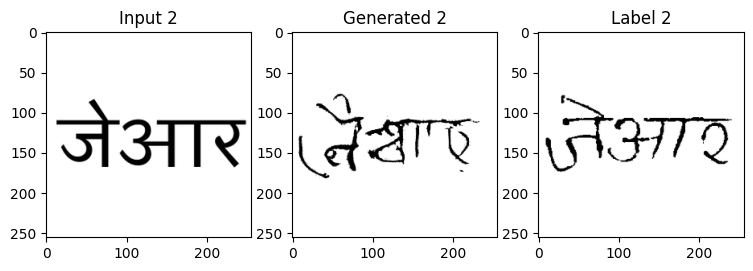

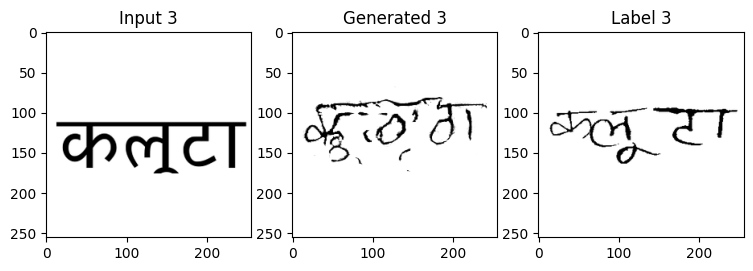

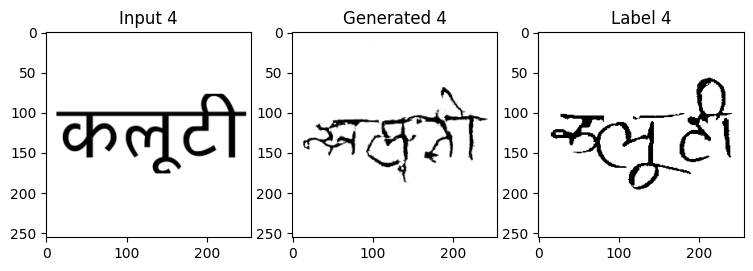

 50%|█████     | 1/2 [00:05<00:05,  5.02s/it]

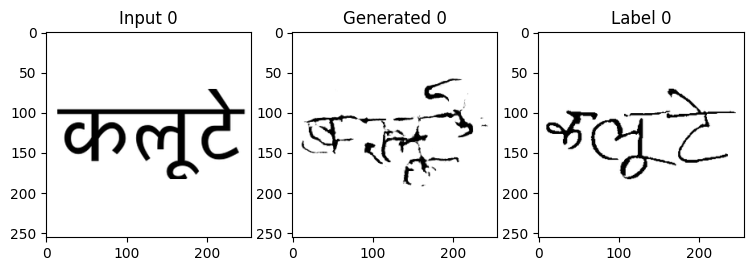

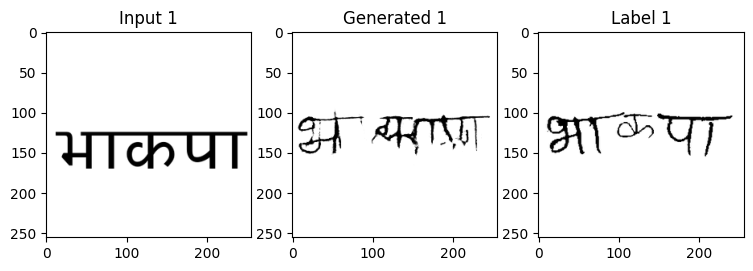

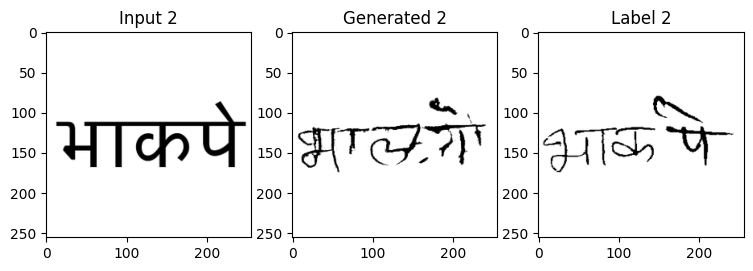

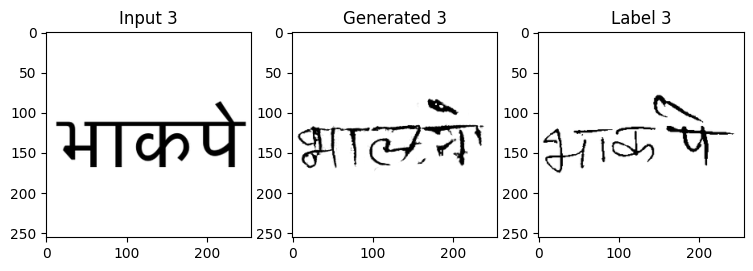

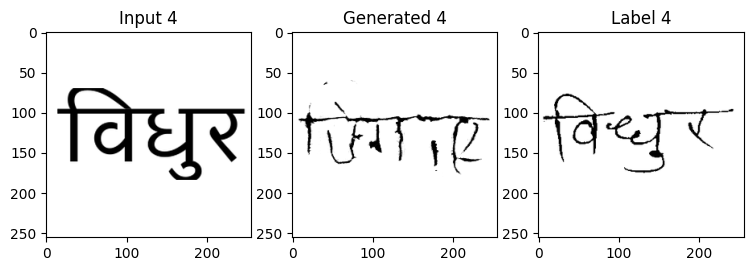

100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


In [11]:
loop = tqdm(val_loader, leave=True)

for idx, (x, y) in enumerate(loop):
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    # Train Discriminator
    with torch.amp.autocast('cuda'):
        y_fake = gen(x)
        for i in range(5):
            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(x[i].detach().cpu().numpy()[0], cmap='gray')
            plt.title(f'Input {i}')
            plt.subplot(1, 3, 2)
            plt.imshow(y_fake[i].detach().cpu().numpy()[0], cmap='gray')
            plt.title(f'Generated {i}')
            plt.subplot(1, 3, 3)
            plt.imshow(y[i].detach().cpu().numpy()[0], cmap='gray')
            plt.title(f'Label {i}')
            plt.show()